In this lab, you will implement the Isomap algorithm. Given a data matrix, you should (1) construct a neighborhood graph (2) approximate geodesic using shortest path algorithm (Floyd's algorithms). Then you run MDS to find a low dimensional representation corresponding to Isomap.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import ticker
import mpl_toolkits.mplot3d

from sklearn import manifold, datasets

# We will use data sampled from the swiss roll manifold
n_samples = 1000
S_points, S_color = datasets.make_swiss_roll(n_samples, random_state=0)

In [2]:
# These are for visualization
def plot_3d(points, points_color, title):
    x, y, z = points.T

    fig, ax = plt.subplots(
        figsize=(7, 7),
        facecolor="white",
        tight_layout=True,
        subplot_kw={"projection": "3d"},
    )
    fig.suptitle(title, size=16)
    col = ax.scatter(x, y, z, c=points_color, s=50, alpha=0.8)
    ax.view_init(azim=-60, elev=9)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.zaxis.set_major_locator(ticker.MultipleLocator(1))

    fig.colorbar(col, ax=ax, orientation="horizontal", shrink=0.6, aspect=60, pad=0.01)
    plt.show()


def plot_2d(points, points_color, title, figsize=(3, 3)):
    fig, ax = plt.subplots(figsize=figsize, facecolor="white", constrained_layout=True)
    fig.suptitle(title, size=16)
    add_2d_scatter(ax, points, points_color)
    plt.show()


def add_2d_scatter(ax, points, points_color, title=None):
    x, y = points.T
    ax.scatter(x, y, c=points_color, s=50, alpha=0.8)
    ax.set_title(title)
    ax.xaxis.set_major_formatter(ticker.NullFormatter())
    ax.yaxis.set_major_formatter(ticker.NullFormatter())

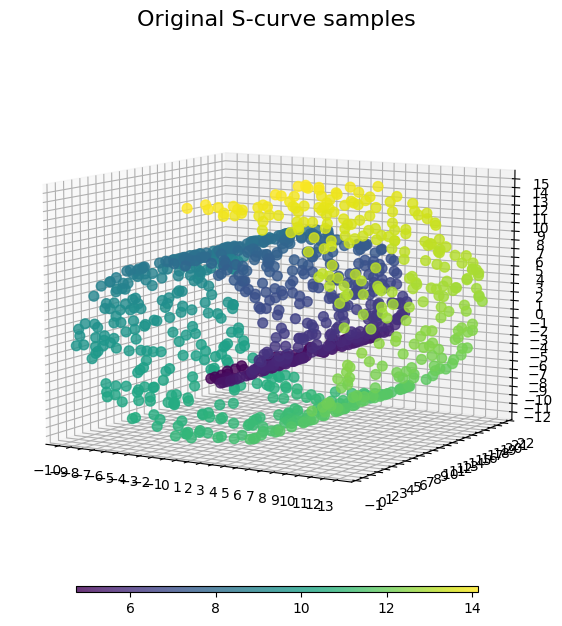

In [3]:
# Plot the data
plot_3d(S_points, S_color, "Original S-curve samples")

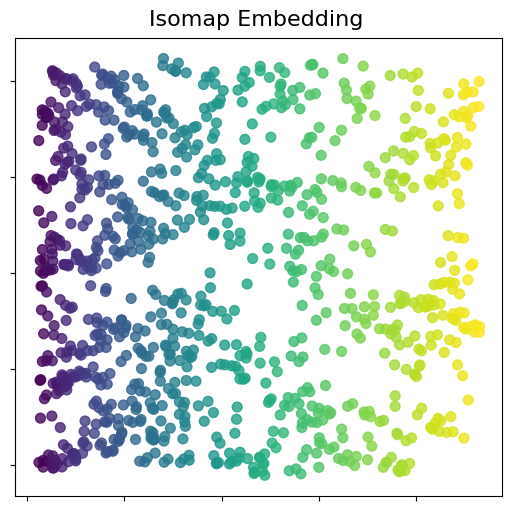

In [4]:
n_neighbors = 12  # number of neighbors for generating a graph
n_components = 2  # number of coordinates for the manifold

isomap = manifold.Isomap(n_neighbors=n_neighbors, n_components=n_components, p=2)
S_isomap = isomap.fit_transform(S_points)

# This plot generates a bit refined version of your own Isomap representation
plot_2d(S_isomap, S_color, "Isomap Embedding", figsize=(5,5))

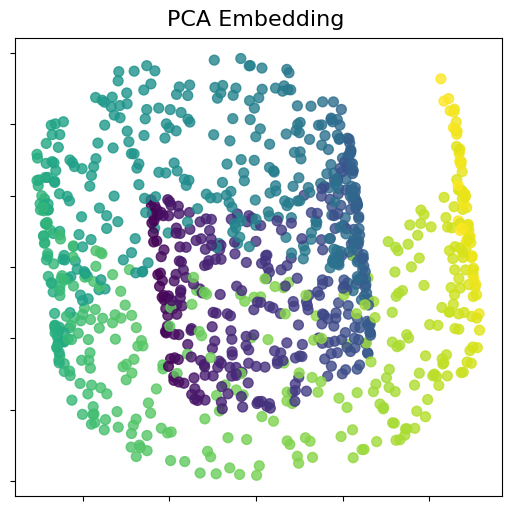

In [5]:
# Unlike Isomap, PCA result cannot unroll the swiss roll
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
S_pca = pca.fit_transform(S_points)

plot_2d(S_pca, S_color, "PCA Embedding", figsize=(5,5))

In [6]:
from sklearn.neighbors import kneighbors_graph

"""TODO: implement the following function."""
def nbd_graph(data: np.ndarray, k: int):
# Here, you will construct the neighbor graph of the following specification.

# The below indicates input/output of the nbd_graph function.
# Input
# data: a data matrix of size n x p
# k: number of neighbors used for constructing a neighbor graph
# Output
# D: a matrix of size n x n whose (i,j)-th entry is zero if i is not a k-nearest
#    neighbor of j and j is not a k-nearest neighbor and is the distance between
#    i and j otherwise
  D = kneighbors_graph(data, n_neighbors=k, mode="distance").toarray()
  D[D == 0] = np.inf
  return D

In [7]:
"""TODO: implement the following function."""
def floyd(M):
# Here, you will the Floyd's algorithm given a weighted graph adjacency matrix
# D.

# The below indicates input/output of the floyd function.
# Input
# M: a weighted graph adjacency matrix of size n x n whose (i,j)-th entry is 
#    zero if (i,j) is not an edge and is corresponding edge weight if (i,j) is
#    an edge
# Output
# G: a matrix of size n x n whose (i,j)-th entry is the shortest distance
#    between nodes i,j
  n = M.shape[0]
  G = M.copy()
  for k in range(n):
    for i in range(n):
      for j in range(n):
        if i == j:
          G[i, j] = 0
        elif j < i:
          G[i, j] = G[j, i]
        else:
          G[i, j] = min(G[i, j], G[i, k] + G[k, j])
  return G


# XXX: This did NOT work for me
def _floyd(M):
  n = M.shape[0]
  G = M.copy()
  
  def st(i, j, k):
    if k == -1 or i == j:
      return M[i, j]
    else:
      return min(st(i, j, k-1),
                 st(i, k, k-1) + st(j, k, k-1))
  
  for i in range(n):
    for j in range(n):
      if i == j:
        G[i, j] = 0
      elif j < i:
        G[i, j] = G[j, i]
      else:
        G[i, j] = st(i, j, k=n-1)
  return G

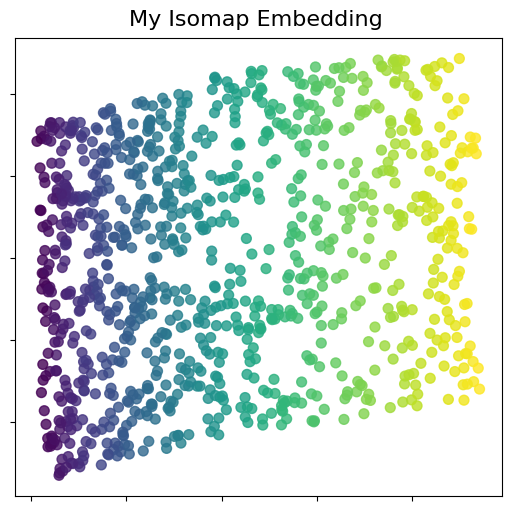

In [8]:
from sklearn.manifold import MDS

# Construct neighbor graph, approximate the geodesic, and apply MDS 
D = nbd_graph(S_points, n_neighbors)
G = floyd(D)
mds = MDS(n_components=2, dissimilarity='precomputed', normalized_stress='auto')
S_mds = mds.fit_transform(G)

plot_2d(S_mds, S_color, "My Isomap Embedding", figsize=(5,5))